# CHiMaD Workshop: COVID-19 Example Notebook

This dataset contains roughly 700 molecules tat were located within COVID19 literature.

In [1]:
import pandas as pd
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from dlhub_sdk.client import DLHubClient
from mdf_forge import Forge
%matplotlib inline

### Retrieving Data with MDF Forge

In [ ]:
mdf = Forge('mdf-test')

dataset_name = "anl_covid19_2020"
r = mdf.match_resource_types("record").match_source_names(dataset_name)
r = r.search()

In [71]:
mdf.match_resource_types("record").match_source_names(dataset_name).\
    match_range("molecule.molecular_weight", start=471, stop=500)
subset, info = mdf.search(limit=100, info=True, reset_query=True)
print('Number of Matches: '+str(info['total_query_matches']))
print('')
mol_weight_smiles = []
for record in subset:
    mol_weight_smiles.append(record['molecule']['smiles'])
    print(record['molecule']['synonyms'][0]+' ---- '+\
          str(record['molecule']['molecular_weight'])+' amu')

Number of Matches: 29

abbv-744 ---- 491.6 amu
arbidol ---- 477.4 amu
umifenovir ---- 477.4 amu
arbidol ---- 477.4 amu
camostat mesylate ---- 494.5 amu
dasatinib ---- 488 amu
imatinib ---- 493.6 amu
silybin ---- 482.4 amu
nicardipine ---- 479.5 amu
sildenafil ---- 474.6 amu
almitrine ---- 477.6 amu
carminic acid ---- 492.4 amu
nicardipine ---- 479.5 amu
conivaptan ---- 498.6 amu
silybin ---- 482.4 amu
idarubicin ---- 497.5 amu
arbidol ---- 477.4 amu
balapiravir ---- 494.5 amu
baloxavir ---- 483.5 amu
dasabuvir ---- 493.6 amu
umifenovir ---- 477.4 amu
arbidol ---- 477.4 amu
dasatinib ---- 488 amu
arzoxifene ---- 475.6 amu
umifenovir ---- 477.4 amu
pralatrexate ---- 477.5 amu
quinacrine hydrochloride ---- 472.9 amu
arbidol ---- 477.4 amu
prednicarbate ---- 488.6 amu


In [84]:
mdf.match_resource_types("record").match_source_names(dataset_name).\
    match_field("molecule.iupac_name", value='amine', required=True)
subset, info = mdf.search(limit=100, info=True, reset_query=True)
print('Amine Functional Group Matches: '+str(info['total_query_matches']))
amine_smiles = []
for rr in subset:
    amine_smiles.append(rr['molecule']['smiles'])

mdf.match_resource_types("record").match_source_names(dataset_name).\
    match_field("molecule.iupac_name", value='fluoro', required=True)
subset, info = mdf.search(limit=100, info=True, reset_query=True)
print('Fluoro Functional Group Matches: '+str(info['total_query_matches']))
fluoro_smiles = []
for rr in subset:
    fluoro_smiles.append(rr['molecule']['smiles'])

Amine Functional Group Matches: 16
Fluoro Functional Group Matches: 29


### Using DLHub to Run and Compare Models

For Reference:

hERG I and II - a gene that codes for proteins controlling K-ion exchange in cell membranes

AMES I - a common bacterial toxicological test

Carc I - a common test for carcinogenicity (ability to cause cancer)

Based on this scale: score of 1 is most toxic, score of 0 is most benign.

In [9]:
DL = DLHubClient()
y_out_DL = DL.run(name ='loganw_globusid/admet_tox', \
                  inputs=all_smiles)

In [24]:
tox_out = pd.DataFrame(np.array(list(y_out_DL.values())).T,columns=y_out_DL.keys())
tox_out.head()

,smiles,T_hERG_II,T_AMES_I,T_Carc_I,T_hERG_I
0,CN(C(=O)COC(=O)Cc1ccc(cc1)OC(=O)c1ccc(cc1)N=C(...,0.3766730614546943,0.1727067306558859,0.322438834040425,0.12280826064597285
1,OCC(Cn1cnc2c1ncnc2N)O,0.19896779145701676,0.6015104748693273,0.13226881138619703,0.13241346970563753
2,CC(C12CC3CC(C2)CC(C1)C3)N,0.08067164842284695,0.3462332723716513,0.0692546979724032,0.13313487130002913
3,OCC(Cn1ccc(nc1=O)N)OCP(=O)(O)O,0.24052601576518745,0.09202143455196388,0.16065251954250265,0.1607802069678012
4,OCC1OC(Oc2cc3OC(CC(=O)c3c(c2)O)c2ccc(c(c2)O)OC...,0.28892589195747925,0.30248856165990945,0.05533363434424185,0.14345901051853016


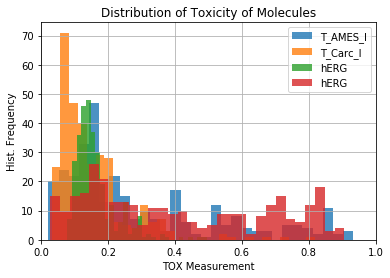

In [96]:
plt.figure()
plt.hist(np.array(tox_out['T_AMES_I'],dtype=np.float64),30,alpha=0.8,label='T_AMES_I')
plt.hist(np.array(tox_out['T_Carc_I'],dtype=np.float64),30,alpha=0.8,label='T_Carc_I')
plt.hist(np.array(tox_out['T_hERG_I'],dtype=np.float64),30,alpha=0.8,label='hERG')
plt.hist(np.array(tox_out['T_hERG_II'],dtype=np.float64),30,alpha=0.8,label='hERG')
plt.xlim([0,1])
plt.xlabel('TOX Measurement')
plt.ylabel('Hist. Frequency')
plt.title('Distribution of Toxicity of Molecules')
plt.legend()
plt.grid()
plt.show()

In [85]:
y_out_amine = DL.run(name = 'loganw_globusid/admet_tox', \
                  inputs=amine_smiles)
y_out_fluoro = DL.run(name = 'loganw_globusid/admet_tox', \
                  inputs=fluoro_smiles)
tox_out_amine = pd.DataFrame(np.array(list(y_out_amine.values())).T,\
                             columns=y_out_amine.keys())
tox_out_fluoro = pd.DataFrame(np.array(list(y_out_fluoro.values())).T,\
                             columns=y_out_fluoro.keys())

In [86]:
tox_out_amine.head()

,smiles,T_hERG_II,T_AMES_I,T_Carc_I,T_hERG_I
0,NC12CC3CC(C2)CC(C1)C3,0.08608340947676724,0.2232309850193229,0.1489027312185909,0.16023652258396104
1,Nc1c2CCCCc2nc2c1cccc2,0.3845554610252374,0.8331459125060198,0.060973776436298276,0.11832655239476667
2,NC12CC3CC(C2)CC(C1)C3,0.08608340947676724,0.2232309850193229,0.1489027312185909,0.16023652258396104
3,CC(Cc1ccccc1)(N)C,0.07414654375019278,0.04506849646048297,0.3344128646752374,0.13501421155928722
4,Nc1cc(nc(=N)n1O)N1CCCCC1,0.8559482605754931,0.7666147068185877,0.2663495817740153,0.34129844840281426


In [87]:
tox_out_fluoro.head()

,smiles,T_hERG_II,T_AMES_I,T_Carc_I,T_hERG_I
0,Fc1c[nH]c(=O)c(n1)C(=O)N,0.13121689667422953,0.41610594542109125,0.11545496183032491,0.1020209108014817
1,CCCc1cc(F)ccc1C(c1ncc[nH]1)O,0.24359381523638987,0.14455481508783335,0.1897581809095928,0.16915152055029892
2,Fc1c[nH]c(=O)c(n1)C(=O)N,0.13121689667422953,0.41610594542109125,0.11545496183032491,0.1020209108014817
3,Fc1c[nH]c(=O)c(n1)C(=O)N,0.13121689667422953,0.41610594542109125,0.11545496183032491,0.1020209108014817
4,NC(=O)CCCN=C(c1cc(F)ccc1O)c1ccc(cc1)Cl,0.646756656328164,0.12494980584559724,0.20286062484423123,0.10803620071112574


### Comparing Toxicity of Amine Groups Versus Fluoro Groups

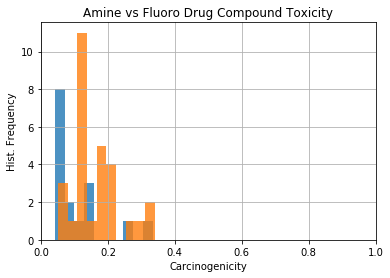

In [94]:
plt.figure()
plt.hist(np.array(tox_out_amine['T_Carc_I'],dtype=np.float64),10,alpha=0.8)
plt.hist(np.array(tox_out_fluoro['T_Carc_I'],dtype=np.float64),10,alpha=0.8)
plt.xlim([0,1])
plt.xlabel('Carcinogenicity')
plt.ylabel('Hist. Frequency')
plt.title('Amine vs Fluoro Drug Compound Toxicity')
plt.grid()
plt.show()

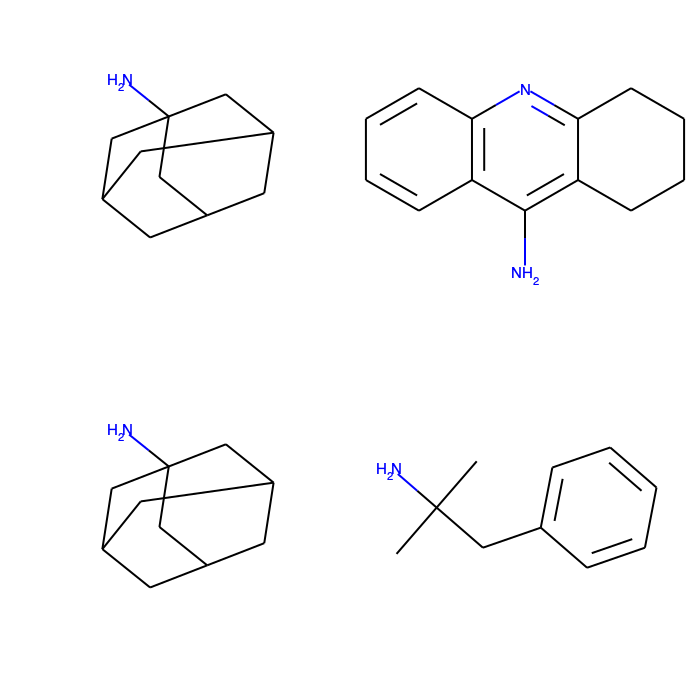

In [97]:
n_mols = 4
ms = [Chem.MolFromSmiles(sm) for sm in amine_smiles[:4]]
Chem.Draw.MolsToGridImage(ms,molsPerRow=2, subImgSize=(350, 350))